# Setup

### Import libraries

In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

### Prepare the datasets

In [2]:
CLASSES = ['Corrosionstain', 'Cracks', 'Exposedbars', 'Spalling']

TRAIN_DIR = "BiNet_Dataset/training"
VAL_DIR = "BiNet_Dataset/validation"
TEST_DIR = "BiNet_Dataset/testing"

### Set GPU memory growth

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Create Generators

In [4]:
scale_gen = ImageDataGenerator(
    rescale=1.0/255,
)

In [5]:
IMG_WIDTH = IMG_HEIGHT = 128
BATCH_SIZE = 32

train_generator = scale_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = scale_gen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = scale_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2428 images belonging to 4 classes.
Found 347 images belonging to 4 classes.
Found 696 images belonging to 4 classes.


# Model Training

### Create Model

In [6]:
# Trial 1: Baseline Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(len(CLASSES), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734158068.318180    3086 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### Model Summary

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,257,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,258,564 (62.02 MB)

 Trainable params: 16,258,564 (62.02 MB)

 Non-trainable params: 0 (0.00 B)

### Fit Model

In [8]:
model_hist = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1734158070.023108    3314 service.cc:148] XLA service 0x7ff90000aed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734158070.023339    3314 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-14 14:34:30.057068: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734158070.170549    3314 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/76 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.5503 - loss: 14.5483

I0000 00:00:1734158071.655882    3314 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 197ms/step - accuracy: 0.3996 - loss: 8.7561 - val_accuracy: 0.5937 - val_loss: 0.9836
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.6654 - loss: 0.8941 - val_accuracy: 0.6744 - val_loss: 0.8870
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.7785 - loss: 0.6666 - val_accuracy: 0.6772 - val_loss: 0.8507
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.8466 - loss: 0.4683 - val_accuracy: 0.7349 - val_loss: 0.8249
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.9057 - loss: 0.3193 - val_accuracy: 0.6974 - val_loss: 0.9921
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.9223 - loss: 0.2582 - val_accuracy: 0.7118 - val_loss: 0.9423
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9566 - loss: 0.1779 - val_accuracy: 0.6888 - val_loss: 1.2915
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.9705 - loss: 0.1321 - val_accuracy: 0.6945 - 

# Evaluate Model

### Evaluate the training and validation data

In [29]:
def plot_training_history(history):
    """
    Plot the training history of the model using Seaborn.

    Parameters:
    - history: History object containing the training history.

    Returns:
    - None (displays the plots)
    """
    
    # Extracting data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Creating DataFrames for plotting
    epochs = range(1, len(acc) + 1)
    
    # Data for accuracy
    acc_data = {
        'Epoch': list(epochs) * 2,
        'Value': acc + val_acc,
        'Metric': ['Training Accuracy'] * len(acc) + ['Validation Accuracy'] * len(val_acc)
    }
    acc_df = pd.DataFrame(acc_data)

    # Data for loss
    loss_data = {
        'Epoch': list(epochs) * 2,
        'Value': loss + val_loss,
        'Metric': ['Training Loss'] * len(loss) + ['Validation Loss'] * len(val_loss)
    }
    loss_df = pd.DataFrame(loss_data)

    # Creating side-by-side plots
    plt.figure(figsize=(12, 4))

    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(data=acc_df, x='Epoch', y='Value', hue='Metric', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(data=loss_df, x='Epoch', y='Value', hue='Metric', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


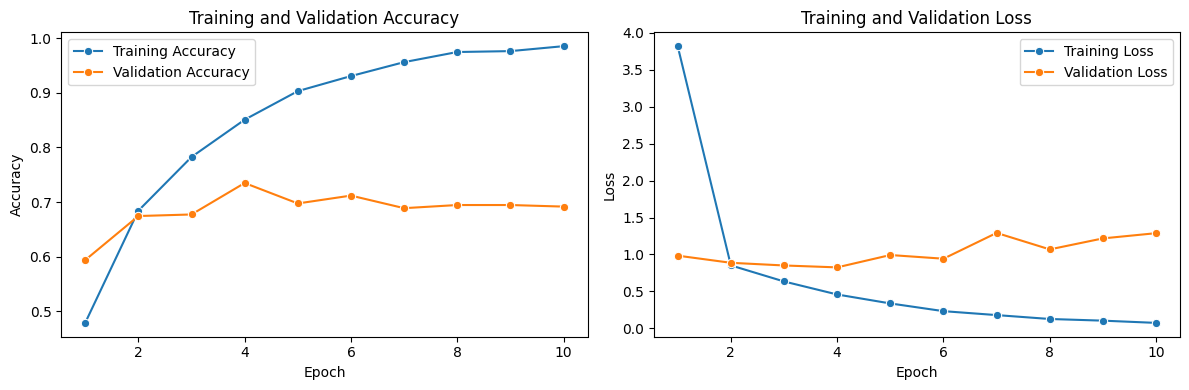

In [30]:
plot_training_history(model_hist)

### Evaluate the test data

In [13]:
model.evaluate(test_generator)

/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.8232 - loss: 0.7385


[1.0714378356933594, 0.7543103694915771]

The accuracy is good at about 82%, but the loss is bad  at about 73%.

### Display predictions on the the testing images samples

In [51]:
def plot_predictions(model, test_generator, classes, num_images=32, grid_shape=(4, 8)):
    """
    Plots a grid of images from the test generator with their true and predicted labels.
    Labels are colored green if the prediction is correct, and red otherwise.

    Parameters:
    - model: Trained Keras model for predictions.
    - test_generator: A Keras ImageDataGenerator iterator for the test set.
    - classes: List of class names corresponding to the model's output.
    - num_images: Number of images to display. Default is 32.
    - grid_shape: Tuple defining the grid layout (rows, cols). Default is (4, 8).
    """
    # Get a batch of images and true labels from the test generator
    images, true_labels = next(test_generator)
    true_labels_indices = np.argmax(true_labels, axis=1)  # Convert one-hot to class indices

    # Predict the labels for the batch of images
    predicted_labels = model.predict(images)
    predicted_labels_indices = np.argmax(predicted_labels, axis=1)

    # Define a helper function to get the label and its color
    def get_label_color(true_idx, pred_idx):
        label_name = classes[true_idx]
        pred_name = classes[pred_idx]
        color = "green" if true_idx == pred_idx else "red"
        return f"{pred_name}", label_name, color

    # Determine grid size
    rows, cols = grid_shape
    total_slots = rows * cols
    num_images = min(num_images, total_slots, len(images))  # Adjust based on available images

    # Create the plot
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= num_images:  # Disable unused axes
            ax.axis('off')
            continue

        pred_name, label_name, color = get_label_color(true_labels_indices[i], predicted_labels_indices[i])

        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(f"Class: {label_name}\n Prediction:{pred_name}", color=color, fontsize=10)

    plt.tight_layout()
    plt.show()

# Example Usage:
# Replace 'your_model.h5' with the actual path to your model
# model = load_model('your_model.h5')
# plot_predictions(model, test_generator, CLASSES, num_images=32, grid_shape=(4, 8))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


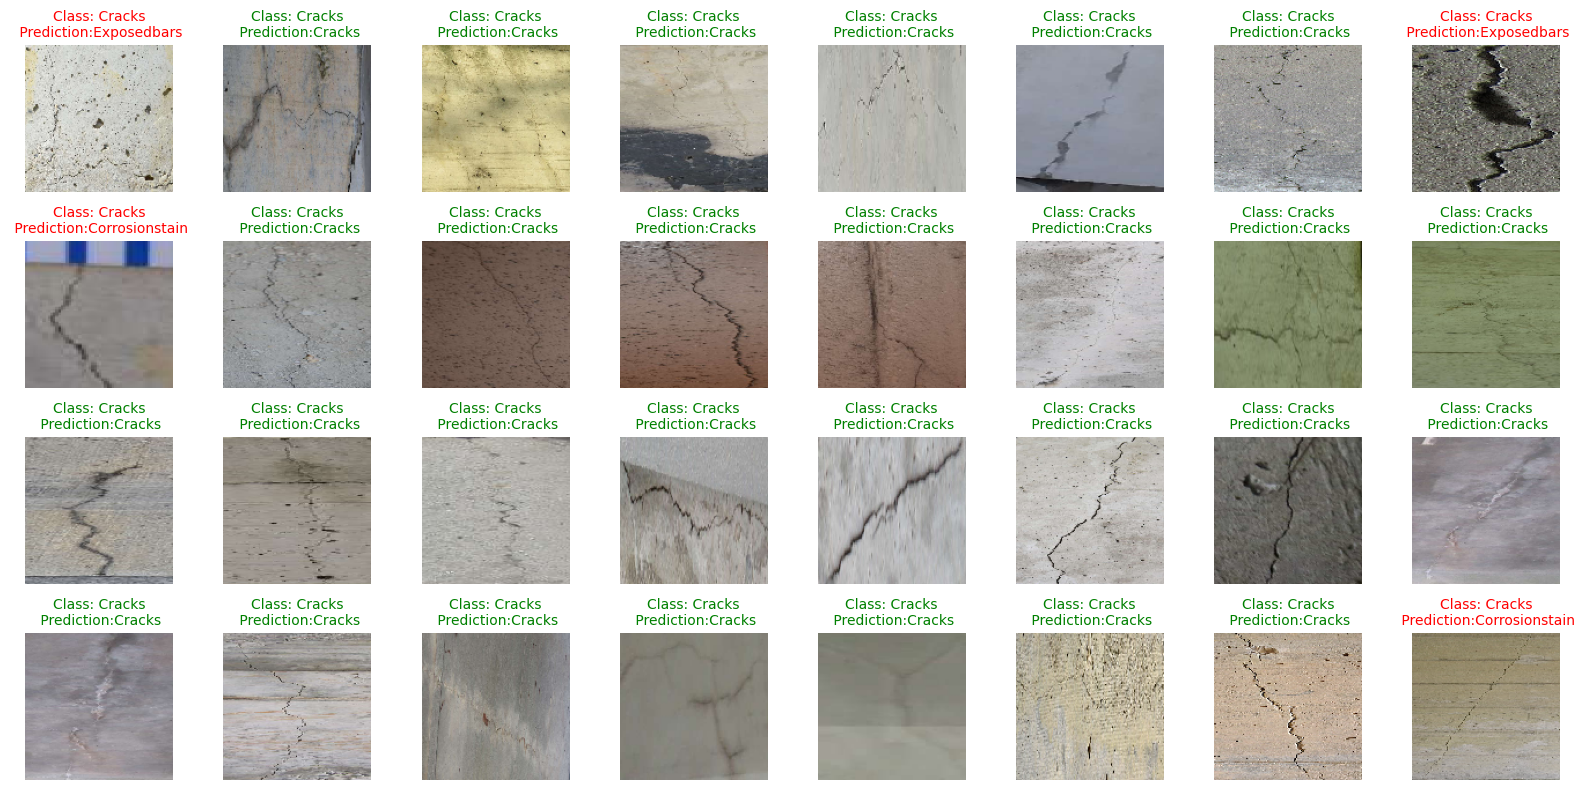

In [57]:
plot_predictions(model, test_generator, CLASSES, num_images=32, grid_shape=(4, 8))

### Create dataframe of the testing data

In [88]:
def create_evaluation_dataframe(model, test_generator, classes):
    """
    Creates a DataFrame summarizing the model's performance on the test data.

    Parameters:
    - model: Trained Keras model for predictions.
    - test_generator: A Keras ImageDataGenerator iterator for the test set.
    - classes: List of class names corresponding to the model's output.

    Returns:
    - DataFrame containing filenames, true labels, predicted labels, prediction confidence, and correctness.
    """
    # Get all images and labels from the test generator
    test_generator.reset()  # Reset the generator to ensure we process all test data
    filenames = test_generator.filenames
    true_labels_one_hot = test_generator.classes  # Class indices for true labels

    # Predict the labels for the entire test set
    predictions = model.predict(test_generator, verbose=1)
    predicted_labels_indices = np.argmax(predictions, axis=1)  # Class indices for predictions
    prediction_confidences = np.max(predictions, axis=1)  # Max confidence for each prediction

    # Map indices to class names
    true_labels_names = [classes[idx] for idx in true_labels_one_hot]
    predicted_labels_names = [classes[idx] for idx in predicted_labels_indices]

    # Determine correctness
    correct_predictions = (predicted_labels_indices == true_labels_one_hot)

    # Create the DataFrame
    df = pd.DataFrame({
        "Filename": filenames,
        "Damage Type": true_labels_names,
        "Prediction": predicted_labels_names,
        "Prediction Confidence": prediction_confidences,
        "Correct Prediction": correct_predictions
    })

    return df


In [91]:
eval_df = create_evaluation_dataframe(model, test_generator, CLASSES)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


### Check the average prediction confidence

In [107]:
def plot_average_confidence(eval_df):
    """
    Plot average confidence for each class.
    Parameters:
    - eval_df: DataFrame containing evaluation results.
    
    Returns:
    - None (displays the plot)
    """
    
    # Calculate average confidence
    average_confidence = eval_df.groupby('Prediction')['Prediction Confidence'].mean().reset_index()
    average_confidence.columns = ['Prediction', 'Average Confidence']
    
    # Create a bar plot with hue set to 'Prediction' and legend turned off
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Prediction', y='Average Confidence', data=average_confidence, hue='Prediction', palette='viridis', legend=False)
    plt.title('Average Confidence by Prediction')
    plt.xlabel('Prediction')
    plt.ylabel('Average Confidence (%)')
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    plt.tight_layout()
    plt.show()

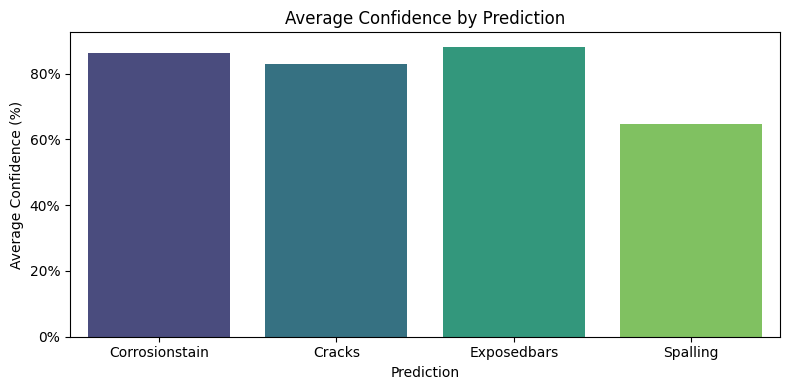

In [108]:
plot_average_confidence(eval_df)

Spalling only has a few image samples compared to the other classes, so it has lower predicction confidence compared to the other classes. 

### Check the average prediction accuracy

In [129]:
def plot_accuracy_per_class(eval_df):
    """
    Plots the accuracy per class for each damage type.
    Parameters:
    - eval_df: DataFrame containing evaluation results.
    
    Returns:
    - None (displays the plot)
    """
    # Calculate accuracy per class
    accuracy_per_class = eval_df.groupby('Damage Type').apply(
        lambda x: (x['Prediction'] == x['Damage Type']).mean()
    ).reset_index()
    
    accuracy_per_class.columns = ['Damage Type', 'Accuracy']
    
    # Create a box plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Damage Type', y='Accuracy', data=accuracy_per_class, palette='viridis')
    
    plt.title('Accuracy per Damage Type')
    plt.xlabel('Damage Type')
    plt.ylabel('Accuracy (%)')
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
# plot_accuracy_per_class(eval_df)


/tmp/ipykernel_3086/1477179811.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_class = eval_df.groupby('Damage Type').apply(
/tmp/ipykernel_3086/1477179811.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Damage Type', y='Accuracy', data=accuracy_per_class, palette='viridis')


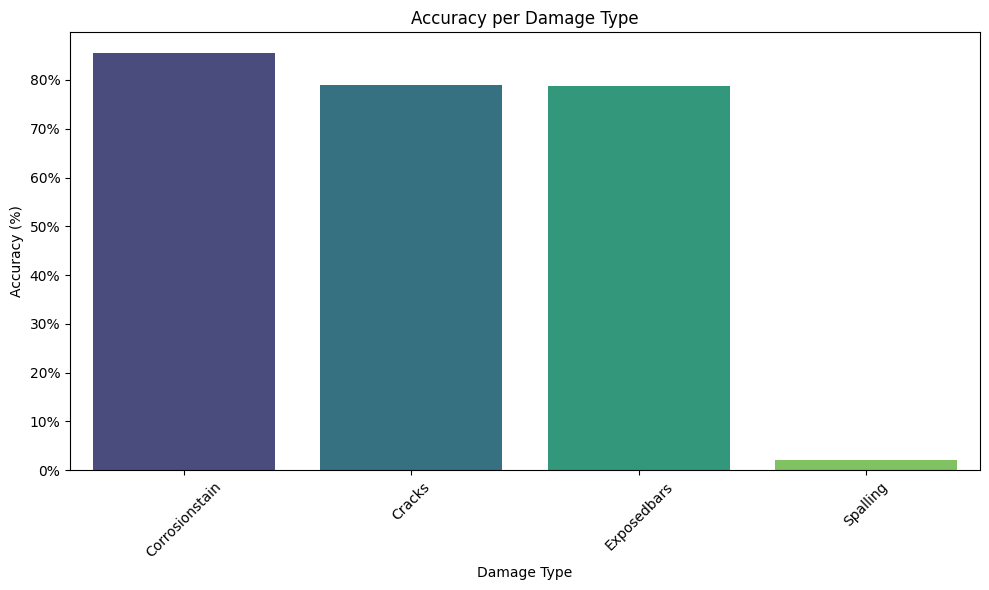

In [128]:
plot_accuracy_per_class(eval_df)

Spalling is expected to have low accuracy but I did not expected it to be this low.

### Confusion matrix

In [137]:
def plot_class_correlation(y_true, y_pred, class_names):
    """
    Plots a confusion matrix for the given true and predicted labels.
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - class_names: List of class names
    
    Returns:
    - None (displays the plot)
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title('Confusion Matrix\n')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

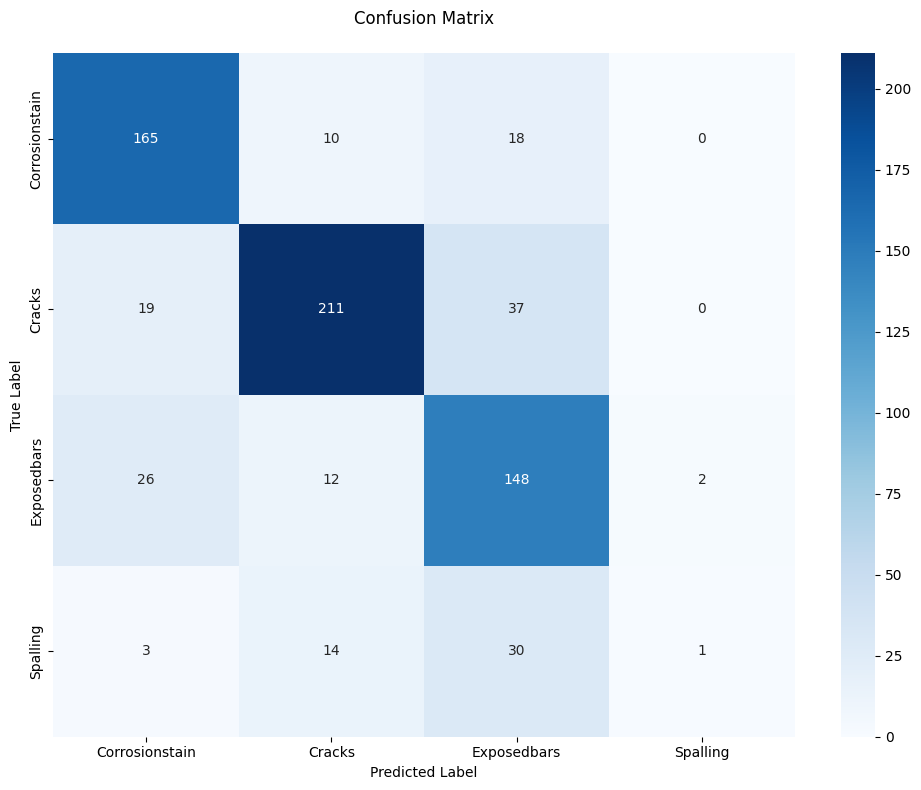

In [138]:
plot_class_correlation(eval_df['Damage Type'], eval_df['Prediction'], eval_df['Damage Type'].unique())

Spalling is more likely and more commonly to be misclassified as exposed bars compared to its own class. I did not expect this so I searched for the definition of spalling and found that it is the corrosion of a larger body, which in the case of the images is concrete. Corrosion of concrete will result in exposed bars. This is why spalling is more likely to be misclassified as exposed bars. (Interesting fact since I did not research the definitions of the classes beforehand)

### Image comparison

In [225]:
def plot_images_by_label(generator, class_labels, target_label, nb_img=12):
    """
    Plot images from the generator that match the specified class label.

    Parameters:
    - generator (keras.preprocessing.image.ImageDataGenerator): Image data generator.
    - class_labels (list): List of class labels.
    - target_label (str): The class label to filter images by.
        
    Returns:
    - None (displays the plot)
    """
    
    # Get a batch of images and labels from the generator
    images, labels = next(generator)
    
    # Find indices of the target label
    target_indices = [i for i, label in enumerate(labels) if np.argmax(label) == class_labels.index(target_label)]
    
    # Plot the images that match the target label
    plt.figure(figsize=(16, 8))
    for i, idx in enumerate(target_indices[:nb_img]):  # Limit to 12 images
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[idx])
        plt.title(target_label)
        plt.axis('off')
    plt.show()

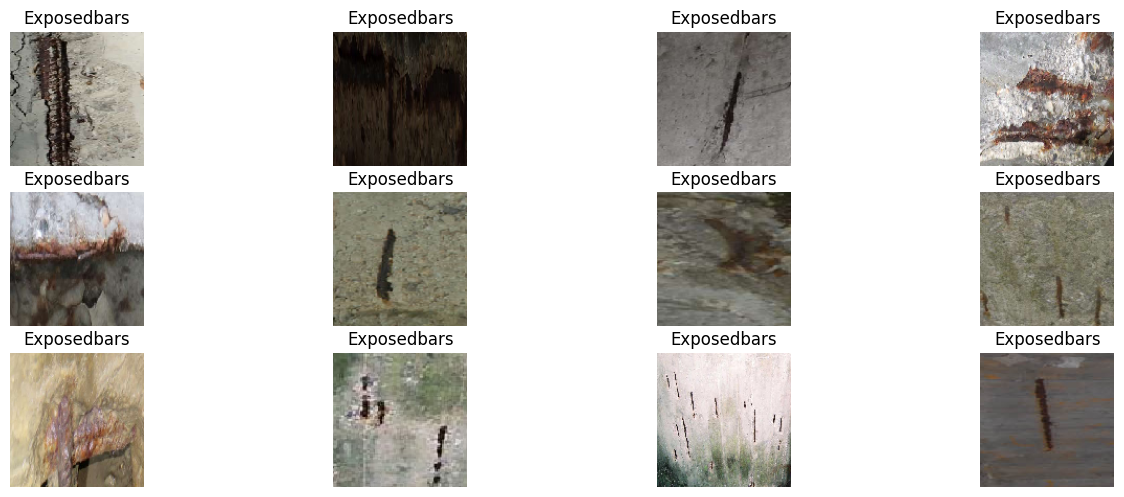

In [231]:
class_labels = list(test_generator.class_indices.keys())
plot_images_by_label(test_generator, class_labels, 'Exposedbars')

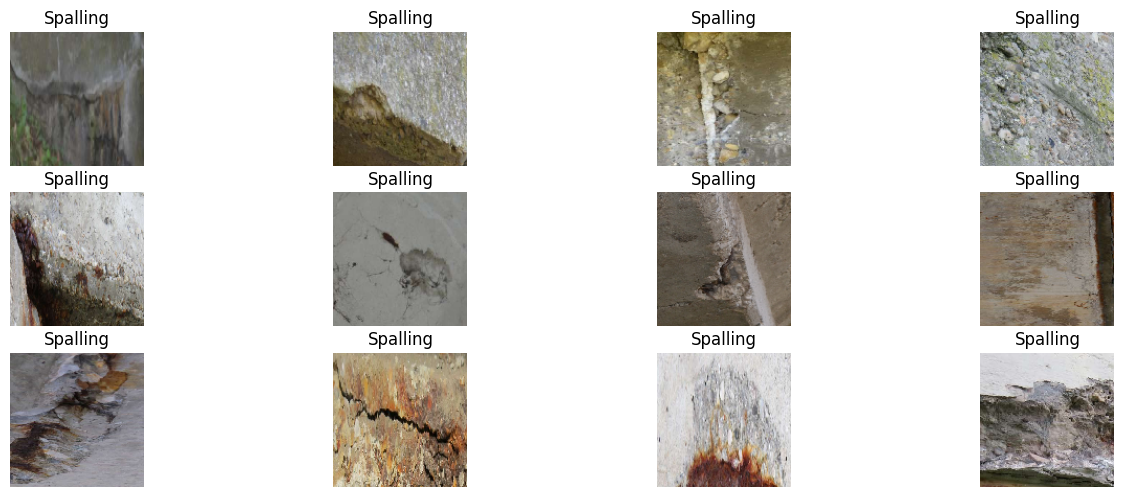

In [237]:
plot_images_by_label(test_generator, class_labels, 'Spalling')

Spalling is the corrosion of a larger body, in this case the concrete, and exposed bars are often the result of spalling. In the next trials, the spalling class and the exposed bar class were combined into one Spalling class. (This will also address the class imbalance problem.)

# Save model

In [238]:
model.save("models/trial_1.keras")